In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
from functools import reduce
%matplotlib inline

In [2]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Demorgraphics

In [4]:
demographics = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_questionnaire-zk38.csv', sep = ",")
#demographics.head(15)
# we asked them 7 questions in total

In [5]:
demographics = demographics[demographics['Question Key'] != 'BEGIN QUESTIONNAIRE']
demographics = demographics[demographics['Question Key'] != 'END QUESTIONNAIRE']
demographics['id'] = demographics['Participant Private ID']
demographics['question'] = demographics['Question Key']
demographics['response'] = demographics['Response']
demographics = demographics[['id', 'question', 'response']]

In [6]:
d = pd.pivot_table(demographics, index = 'id', columns = 'question', values = 'response', aggfunc='first')
d = d.reset_index()
d.columns= ['id','age', 'confirmation_1', 'confirmation_2', 'gender', 'gender_numeric','handedness', 'handedness_numeric', 'degree', 'degree_numeric']


In [7]:
d['age'].astype(float).mean()

39.2

In [8]:
d['age'].astype(float).std()

10.405464151614108

In [9]:
d.groupby('gender').nunique()

id  age  confirmation_1  confirmation_2  gender  gender_numeric  \
gender                                                                    
Female  14   13               1               1       1               1   
Male     6    6               1               1       1               1   

        handedness  handedness_numeric  degree  degree_numeric  
gender                                                          
Female           2                   2       3               3  
Male             1                   1       2               2

In [11]:
d.to_csv('noprescreen_dataset/demographics_v2_20.csv', sep = ',', encoding='utf-8')

# Sound Check

In [13]:
# do a quick check for sound
sound = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-jgum.csv', sep = ",")
sound = sound.replace('null', np.nan)
sound = sound.replace('nan', np.nan)


In [14]:
sound = sound[np.isfinite(sound['button pressed'])]

In [15]:
correct = [1, 0, 0]* 20

In [16]:
s = (sound['button pressed'] == correct).reset_index(name = 'check')
sound = sound.reset_index()
sound = pd.merge(s[['index', 'check']], sound, on = 'index')
sound_final= sound[['Participant Private ID','button pressed','check']]

In [17]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)
sound_final.head(300)

Participant Private ID  button pressed  check
0               765957.000           1.000   True
1               765957.000           0.000   True
2               765957.000           0.000   True
3               765963.000           1.000   True
4               765963.000           0.000   True
5               765963.000           0.000   True
6               765965.000           1.000   True
7               765965.000           0.000   True
8               765965.000           0.000   True
9               765970.000           1.000   True
10              765970.000           0.000   True
11              765970.000           0.000   True
12              765973.000           0.000  False
13              765973.000           0.000   True
14              765973.000           0.000   True
15              765978.000           1.000   True
16              765978.000           0.000   True
17              765978.000           0.000   True
18              765983.000           1.000   True
19              765983.000           0.000   True
20              765983.000           0.000   True
21              765982.000           1.000   True
22              765982.000           0.000   True
23              765982.000           0.000   True
24              765985.000           1.000   True
25              765985.000           0.000   True
26              765985.000           0.000   True
27              765987.000           1.000   True
28              765987.000           0.000   True
29              765987.000           0.000   True
30              765991.000           1.000   True
31              765991.000           0.000   True
32              765991.000           0.000   True
33              765992.000           1.000   True
34              765992.000           0.000   True
35              765992.000           0.000   True
36              765993.000           1.000   True
37              765993.000           0.000   True
38              765993.000           0.000   True
39              765995.000           1.000   True
40              765995.000           0.000   True
41              765995.000           0.000   True
42              766000.000           1.000   True
43              766000.000           0.000   True
44              766000.000           0.000   True
45              766002.000           1.000   True
46              766002.000           0.000   True
47              766002.000           0.000   True
48              766005.000           1.000   True
49              766005.000           0.000   True
50              766005.000           0.000   True
51              766004.000           1.000   True
52              766004.000           0.000   True
53              766004.000           0.000   True
54              766092.000           1.000   True
55              766092.000           0.000   True
56              766092.000           0.000   True
57              766229.000           1.000   True
58              766229.000           0.000   True
59              766229.000           0.000   True

# Rod fixing count

In [18]:
#import csv
#2jau and 5e3j are low-high and high-low
df1 = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-i9un.csv', sep = ",") # high to low
df2 = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-d74y.csv', sep = ",") # low to high

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#replace all null and nan to the np.nan
df1 = df1.replace('null', np.nan)
df1 = df1.replace('nan', np.nan)
df2 = df2.replace('null', np.nan)
df2 = df2.replace('nan', np.nan)

#turn object into floats and round them and rename them
df1['end_time'] = round(df1['end_time'].astype(float))
df1['start_time'] = round(df1['start_time'].astype(float))
df1['builtin_rt'] = df1['builtin rt'].astype(float) #dont round up builtin reaction time
df1['quality_check'] = df1['rod fixing checked'].astype(float)
df1['id'] = df1['Participant Private ID']
df1['function_id'] = df1['function id']
df1['round_instance'] = df1['round instance']
df1['trial_index'] = df1['index']
df1['key_pressed'] = df1['key pressed']

df2['end_time'] = round(df2['end_time'].astype(float))
df2['start_time'] = round(df2['start_time'].astype(float))
df2['builtin_rt'] = df2['builtin_rt'].astype(float) #dont round up builtin reaction time
df2['quality_check'] = df2['rod fixing checked'].astype(float)
df2['id'] = df2['Participant Private ID']
df2['round_instance'] = df2['round_instance']
df2['function_id'] = df2['function id']
df2['trial_index'] = df2['index']
df2['key_pressed'] = df2['key pressed']

In [20]:
#select columns from df1 and df2
data1 = df1[['trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed']]
data2 = df2[['trial_index','id','price_displayed', 'key pressed','environment', 'order', 
           'round_instance', 'task', 'function_id', 'quality_check', 
           'builtin_rt', 'end_time', 'start_time', 'Participant Public ID', 'key_pressed']]

In [21]:
data1['order'] = ['high-low']*len(data1)
data2['order'] = ['low-high']*len(data2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
data = pd.concat([data1, data2])
data.index.nunique()
index_manual = list(range(0, len(data)))
data['index'] = index_manual
data = data.set_index('index')
data = data[data.function_id != 'caller']
data = data[pd.notnull(data['function_id'])]



In [23]:
data_useful = data[(data.function_id == "rod_fixing")|(data.function_id == "fishing_l")|(data.function_id == "fishing_h")]
data_useful = data_useful.sort_values(by = ['id', 'start_time'])


In [24]:
data_useful['trial_label'] = data_useful[['trial_index', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [25]:
d = data_useful.groupby(['id', 'round_instance'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')


In [26]:
data_useful['latency'] = d['latency']
data_useful= data_useful.sort_index().sort_values(['id', 'start_time'])
#data_useful.head(400)

In [27]:
data_rod = data_useful[(data_useful.function_id == "rod_fixing")]

In [28]:
by_environment = data_rod.groupby(['id', 'trial_label']).count().reset_index()
by_environment

id trial_label  trial_index  price_displayed  key pressed  \
0   765957.000   11.0 11.0            8                8            8   
1   765957.000   11.0 12.0            8                8            8   
2   765957.000   11.0 21.0           29               29           26   
3   765957.000   11.0 22.0            8                8            8   
4   765957.000    3.0 11.0            8                8            8   
5   765957.000    3.0 12.0            8                8            8   
6   765957.000    4.0 21.0            7                7            7   
7   765957.000    7.0 11.0            7                7            7   
8   765957.000    7.0 12.0            8                8            8   
9   765957.000    8.0 21.0            8                8            8   
10  765957.000    8.0 22.0            8                8            8   
11  765963.000   11.0 11.0            8                8            8   
12  765963.000   11.0 12.0            8                8            8   
13  765963.000   11.0 21.0            8                8            8   
14  765963.000   11.0 22.0            8                8            8   
15  765963.000    3.0 11.0            8                8            8   
16  765963.000    3.0 12.0            8                8            8   
17  765963.000    4.0 21.0            8                8            8   
18  765963.000    4.0 22.0            8                8            8   
19  765963.000    7.0 11.0            8                8            8   
20  765963.000    7.0 12.0            8                8            8   
21  765963.000    8.0 21.0            8                8            8   
22  765963.000    8.0 22.0            8                8            8   
23  765965.000   11.0 11.0            8                8            8   
24  765965.000   11.0 12.0            8                8            8   
25  765965.000   11.0 21.0            8                8            8   
26  765965.000   11.0 22.0            8                8            8   
27  765965.000    3.0 11.0            7                7            7   
28  765965.000    3.0 12.0            8                8            8   
29  765965.000    4.0 21.0            8                8            8   
30  765965.000    4.0 22.0           17               17           13   
31  765965.000    7.0 11.0            8                8            8   
32  765965.000    7.0 12.0            8                8            8   
33  765965.000    8.0 21.0            8                8            8   
34  765965.000    8.0 22.0            8                8            8   
35  765970.000   11.0 11.0            5                5            5   
36  765970.000   11.0 12.0            8                8            8   
37  765970.000   11.0 21.0            8                8            8   
38  765970.000   11.0 22.0            8                8            8   
39  765970.000    3.0 11.0            8                8            8   
40  765970.000    3.0 12.0            8                8            8   
41  765970.000    4.0 21.0            8                8            8   
42  765970.000    4.0 22.0            8                8            8   
43  765970.000    7.0 11.0            8                8            8   
44  765970.000    7.0 12.0            7                7            7   
45  765970.000    8.0 21.0            8                8            8   
46  765970.000    8.0 22.0            8                8            8   
47  765973.000   11.0 11.0            8                8            8   
48  765973.000   11.0 12.0            8                8            8   
49  765973.000   11.0 21.0            8                8            8   
50  765973.000   11.0 22.0            8                8            8   
51  765973.000    3.0 11.0            2                2            2   
52  765973.000    4.0 21.0            8                8            8   
53  765973.000    4.0 22.0            8                8            8 

# Analysis

In [29]:
data_fish = data_useful[(data_useful.function_id == "fishing_l")|(data_useful.function_id == "fishing_h")]

In [30]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

In [31]:
mask = data_useful.groupby(['id', 'price_displayed', 'trial_index'])['trial_index'].transform(mask_first).astype(bool)
data_useful = data_useful.loc[mask]
# now we got rid of the first spike of fishing and rod fixing

In [33]:
data_fish.to_csv('noprescreen_dataset/fish_v2_20.csv', sep = ',', encoding='utf-8')

In [34]:
mask = data_rod.groupby(['id', 'trial_label'])['trial_label'].transform(mask_first).astype(bool)
data_rod = data_rod.loc[mask]

In [35]:
data_rod.to_csv('noprescreen_dataset/rod_20_no_first_v2_spike.csv', sep = ',', encoding='utf-8')

## Visualization

In [36]:
graph = data_fish.groupby(["price_displayed", "function_id"])['latency'].mean().reset_index()
graph.columns = ['price_displayed', 'function_id', 'average_latency']

In [37]:
data_fish['price_displayed'].unique()

array([0.1, 0.4, 1. , 5.1, 6. , 2.5])

In [38]:
price = [0.1, 0.4, 1, 2.5,  5.1, 6. ]
latency_l = graph.average_latency[(graph.function_id == 'fishing_l')]
latency_h = graph.average_latency[(graph.function_id == 'fishing_h')]

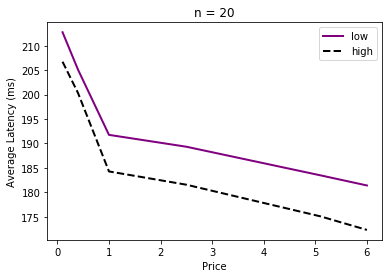

In [117]:
plt.plot( price, latency_l, marker='', color='purple', linewidth=2, label = "low")
plt.plot( price, latency_h, marker='', color='black', linewidth=2, linestyle='dashed', label="high")
plt.title("n = 20")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.savefig('figure/noprescreen/v2.0_price_latency.png', transparent=True, dpi=300)

In [40]:
plot = data_fish.groupby(['id', 'price_displayed', 'environment'])['latency'].mean().reset_index(name = 'average_latency')


<Figure size 7200x8640 with 0 Axes>

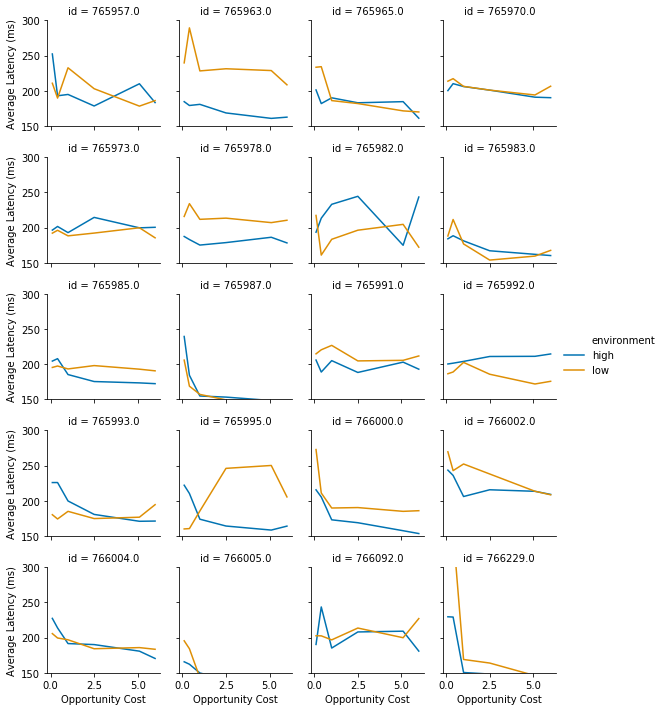

In [41]:
plt.figure(figsize=(100,120))
g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(150, 300))
g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "colorblind", legend = 'full',
      err_style="bars")
g.add_legend()
g.set_axis_labels('Opportunity Cost', 'Average Latency (ms)')
plt.savefig('figure/noprescreen/v2_By subject price and latency.png', dpi = 600, transparent = True)

## Normalization

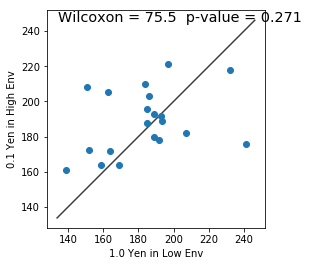

In [42]:
#For normalization, just do a scatterplot across your 100 subjects 
#of median latency 
#for the highest reward in low env vs the equivalent in high env. 
#If 2/3 are on one side of the line, it's an issue.

# Highest reward in low envrionemnt (0.5 pound worth 3000 yen) 2.5 
data_fish_prunned = data_fish
data_low_highest = data_fish_prunned[(data_fish_prunned.environment == 'low')&(data_fish_prunned.price_displayed == 1)]
low_median = data_low_highest.groupby('id')['latency'].median().reset_index(name = 'median_latency')
low_median['median_latency']
# the equivalent of 2.5 in low env is 0.3 in high environment
data_high_equal = data_fish_prunned[(data_fish_prunned.environment == 'high')&(data_fish_prunned.price_displayed == 0.1)]
high_median = data_high_equal.groupby('id')['latency'].median().reset_index(name = 'median_latency')
high_median['median_latency']

fig, ax = plt.subplots()
ax.scatter(low_median['median_latency'], high_median['median_latency'])
ax.set_xlabel('1.0 Yen in Low Env')
ax.set_ylabel('0.1 Yen in High Env')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.annotate('Wilcoxon = 75.5  p-value = 0.271', xy=(0.05, 0.95), xycoords='axes fraction', size = 'x-large')
ax.plot(lims,lims, 'k-', alpha=0.75, zorder=0)
plt.savefig('figure/noprescreen/normalization_v2.0.png', transparent=True, dpi=300)
ax.set_aspect('equal')
# people tap faster in the low environment --> maybe there is a price effect

In [43]:
ss.wilcoxon(low_median['median_latency'], high_median['median_latency'])

WilcoxonResult(statistic=75.5, pvalue=0.2706766375866805)

## Linear regression with predictor fatigue

In [120]:
data_fish_prunned['tap_count']=[1]*len(data_fish_prunned)
# fatigue per environment

In [121]:
tap = data_fish_prunned.groupby(['id', 'environment'])['tap_count'].cumsum().reset_index(name = 'fatigue')

In [46]:
tap = tap.reset_index().set_index('index')

In [47]:
tap = tap.drop('level_0', axis =1)

In [48]:
#tap = tap.set_index('index')
data_fish_prunned = tap.merge(data_fish_prunned, left_index = True, right_index=True,how='outer')

In [118]:
data_fish_prunned.head(100)

fatigue  trial_index         id  price_displayed  key pressed  \
index                                                                  
39723        1        1.000 765957.000            0.100       40.000   
39724        2        1.000 765957.000            0.100       40.000   
39725        3        1.000 765957.000            0.100       40.000   
39726        4        1.000 765957.000            0.100       40.000   
39727        5        1.000 765957.000            0.100       40.000   
39728        6        1.000 765957.000            0.100       40.000   
39729        7        1.000 765957.000            0.100       40.000   
39730        8        1.000 765957.000            0.100       40.000   
39731        9        1.000 765957.000            0.100       40.000   
39732       10        1.000 765957.000            0.100       40.000   
39733       11        1.000 765957.000            0.100       40.000   
39734       12        1.000 765957.000            0.100       40.000   
39735       13        1.000 765957.000            0.100       40.000   
39736       14        1.000 765957.000            0.100       40.000   
39737       15        1.000 765957.000            0.100       40.000   
39738       16        1.000 765957.000            0.100       40.000   
39739       17        1.000 765957.000            0.100       40.000   
39740       18        1.000 765957.000            0.100       40.000   
39741       19        1.000 765957.000            0.100       40.000   
39742       20        1.000 765957.000            0.100       40.000   
39743       21        1.000 765957.000            0.100       40.000   
39744       22        1.000 765957.000            0.100       40.000   
39745       23        1.000 765957.000            0.100       40.000   
39746       24        1.000 765957.000            0.100       40.000   
39747       25        1.000 765957.000            0.100       40.000   
39748       26        1.000 765957.000            0.100       40.000   
39749       27        1.000 765957.000            0.100       40.000   
39750       28        1.000 765957.000            0.100       40.000   
39751       29        1.000 765957.000            0.100       40.000   
39752       30        1.000 765957.000            0.100       40.000   
39753       31        1.000 765957.000            0.100       40.000   
39754       32        1.000 765957.000            0.100       40.000   
39755       33        1.000 765957.000            0.100       40.000   
39756       34        1.000 765957.000            0.100       40.000   
39757       35        1.000 765957.000            0.100       40.000   
39758       36        1.000 765957.000            0.100       40.000   
39759       37        1.000 765957.000            0.100       40.000   
39760       38        1.000 765957.000            0.100       40.000   
39761       39        1.000 765957.000            0.100       40.000   
39762       40        1.000 765957.000            0.100       40.000   
39763       41        1.000 765957.000            0.100       40.000   
39764       42        1.000 765957.000            0.100       40.000   
39765       43        1.000 765957.000            0.100       40.000   
39766       44        1.000 765957.000            0.100       40.000   
39767       45        1.000 765957.000            0.100       40.000   
39768       46        1.000 765957.000            0.100       40.000   
39769       47        1.000 765957.000            0.100       40.000   
39770       48        1.000 765957.000            0.100       40.000   
39771       49        1.000 765957.000            0.100       40.000   
39772       50        1.000 765957.000            0.100       40.000   
39773       51        1.000 765957.000            0.100       40.000   
39774       52        1.000 765957.000            0.100       40.000   
39775       53        1.000 765957.000            0.100       40.000   
39776       54        1.000 765957.000         

In [50]:
len(data_fish_prunned.id.unique())

20

# Linear Mixed Model

In [51]:
data_fish_prunned.isnull().sum()
data_fish_prunned = data_fish_prunned[data_fish_prunned.latency.notnull()]

In [52]:
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='low', 0, data_fish_prunned['environment'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='high', 1, data_fish_prunned['environment'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='low', 0, data_fish_prunned['environment_binary'])
data_fish_prunned['environment_binary'] = np.where(data_fish_prunned['environment']=='high', 1, data_fish_prunned['environment_binary'])
data_fish_prunned['log_latency'] = np.log(data_fish_prunned['latency'])

In [53]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = data_fish_prunned['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = data_fish_prunned)

r = f_model.fit(reml = False, method = 'powell')

#dir(r)
#r.params

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [54]:
print (r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             63238             Method:                       ML         
No. Groups:                   20                Scale:                        0.0622     
Min. group size:              2637              Likelihood:                   -2114.4226 
Max. group size:              3992              Converged:                    Yes        
Mean group size:              3161.9                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.219    0.025 205.369 0.000  5.170  5.269
environment_binary[T.1]             

In [55]:
pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [56]:
random_effects.describe()

Group  environment_binary[T.1]  price_displayed  fatigue
count 20.000                   20.000           20.000   20.000
mean  -0.000                    0.000           -0.000   -0.000
std    0.115                    0.095            0.019    0.000
min   -0.195                   -0.259           -0.064   -0.000
25%   -0.084                   -0.034           -0.005   -0.000
50%    0.025                    0.004            0.001    0.000
75%    0.086                    0.063            0.014    0.000
max    0.200                    0.175            0.019    0.000

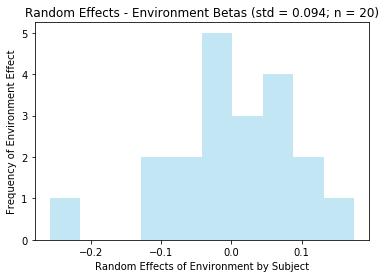

In [58]:
x = random_effects['environment_binary[T.1]']
plt.hist(x, alpha=0.5, label='x', color = 'skyblue')
plt.title('Random Effects - Environment Betas (std = 0.094; n = 20)')
plt.xlabel('Random Effects of Environment by Subject')
plt.ylabel('Frequency of Environment Effect')
plt.savefig('figure/noprescreen/environment_beta_20.png', transparent=True, dpi=300)

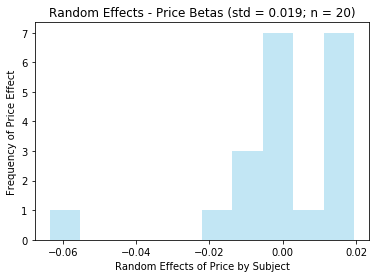

In [59]:
x = random_effects['price_displayed']
plt.hist(x, alpha=0.5, label='x', color = 'skyblue')
plt.title('Random Effects - Price Betas (std = 0.019; n = 20)')
plt.xlabel('Random Effects of Price by Subject')
plt.ylabel('Frequency of Price Effect')
plt.savefig('figure/noprescreen/price_beta_20.png', transparent=True, dpi=300)

## Environment Betas

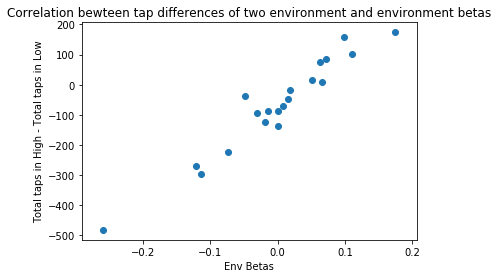

In [60]:
tap = data_fish_prunned.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference')
tap = tap.groupby(tap.index//2)['difference'].diff(-1).dropna().reset_index()

y = -1*tap['difference']
x = random_effects['environment_binary[T.1]']
plt.title('Correlation bewteen tap differences of two environment and environment betas')
plt.xlabel('Env Betas')
plt.ylabel('Total taps in High - Total taps in Low')
plt.scatter(x, y)

# Questionnaires

In [61]:
def extract_choice(ser):
    choice = []
    for s in ser:
        c = 0
        while c < len(s):
            r = json.loads(s[c])
            for key in r.keys():
                choice.append(r[key])
            c = c + 1
    return choice

# AMI

In [62]:
# import AMI
AMI = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-j8g3.csv', sep = ",")
#AMI

In [63]:
AMI_group = AMI.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
# response = AMI_group['choice made'][0]
choice = extract_choice(AMI_group['choice made'])
AMI_group = AMI_group.loc[AMI_group.index.repeat(19)] #repeat no of questions times

In [64]:
# bAMI = questions [5 9 10 11 12 16]
# sAMI = questions [2 3 4  8  15 18]
# eAMI = questions [1 6 7  14 17 19]
AMI_group['choice'] = choice
AMI_group['question_number'] = ["e1", "s2", "s3", "s4", 
                                "b5", "e6", "e7", "s8", 
                                "b9", "b10", "b11", "b12", 
                                "t13", "e14", "s15", "b16", 
                                "e17", "s18", "e19"]*20

In [65]:
AMI_group.choice[AMI_group.choice == "Completely UNTRUE"] = 4
AMI_group.choice[AMI_group.choice == "Mostly untrue"] = 3
AMI_group.choice[AMI_group.choice == "Neither true nor untrue"] = 2
AMI_group.choice[AMI_group.choice == "Quite true"] = 1
AMI_group.choice[AMI_group.choice == "Completely TRUE"] = 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [66]:
bAMI = AMI_group[(AMI_group.question_number == "b5")|(AMI_group.question_number == "b9")|
                 (AMI_group.question_number == "b10")|(AMI_group.question_number == "b11")|
                 (AMI_group.question_number == "b12")|(AMI_group.question_number == "b16")]
sAMI = AMI_group[(AMI_group.question_number == "s2")|(AMI_group.question_number == "s3")|
                 (AMI_group.question_number == "s4")|(AMI_group.question_number == "s8")|
                 (AMI_group.question_number == "s15")|(AMI_group.question_number == "s18")]
eAMI = AMI_group[(AMI_group.question_number == "e1")|(AMI_group.question_number == "e6")|
                 (AMI_group.question_number == "e7")|(AMI_group.question_number == "e14")|
                 (AMI_group.question_number == "e17")|(AMI_group.question_number == "e19")]
trick_AMI = AMI_group[(AMI_group.question_number == "t13")]

In [67]:
pca_table = pd.concat([bAMI, sAMI, eAMI])

In [68]:
pca_table.columns = ['id', 'choice_made', 'choice', 'question_number']
pca_table = pca_table[['id', 'choice', 'question_number']]

In [69]:
bAMI = bAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
bAMI.columns = ['id', 'bAMI']
bAMI['score'] = bAMI['bAMI']/6
sAMI = sAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
sAMI.columns = ['id', 'sAMI']
sAMI['score'] = sAMI['sAMI']/6
eAMI = eAMI.groupby(['Participant Private ID'])['choice'].sum().reset_index()
eAMI.columns = ['id', 'eAMI']
eAMI['score'] = eAMI['eAMI']/6
AMI_final = {'id': bAMI['id'], 'bAMI': bAMI['score'], 'sAMI': sAMI['score'], 'eAMI': eAMI['score']}
AMI_final = pd.DataFrame(data=AMI_final)
AMI_final['tAMI'] = (bAMI['score'] + sAMI['score'] + eAMI['score'])/3

In [70]:
(AMI_final['bAMI']*6).describe()

count   20.000
mean     8.300
std      3.164
min      3.000
25%      6.000
50%      8.500
75%     11.000
max     15.000
Name: bAMI, dtype: float64

In [71]:
1.383 + 0.527

1.9100000000000001

In [72]:
AMI_final.head(30)

id  bAMI  sAMI  eAMI  tAMI
0  765957.000 1.000 1.667 1.167 1.278
1  765963.000 2.000 1.500 1.833 1.778
2  765965.000 2.000 1.667 1.500 1.722
3  765970.000 1.667 1.667 0.833 1.389
4  765973.000 1.833 2.000 0.667 1.500
5  765978.000 0.500 0.833 1.000 0.778
6  765982.000 0.833 1.333 1.000 1.056
7  765983.000 0.500 0.167 0.167 0.278
8  765985.000 1.833 2.667 1.333 1.944
9  765987.000 1.000 0.500 1.833 1.111
10 765991.000 1.500 2.667 2.167 2.111
11 765992.000 2.500 1.833 0.833 1.722
12 765993.000 1.500 1.833 1.333 1.556
13 765995.000 1.000 1.667 1.333 1.333
14 766000.000 1.833 2.000 0.667 1.500
15 766002.000 1.000 2.167 1.333 1.500
16 766004.000 1.167 3.000 1.167 1.778
17 766005.000 1.167 1.667 2.167 1.667
18 766092.000 1.333 1.500 1.000 1.278
19 766229.000 1.500 2.167 0.667 1.444

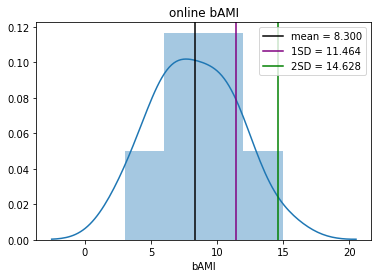

In [73]:
sns.distplot(AMI_final['bAMI']*6)
plt.title('online bAMI')
plt.axvline(x = 8.300, color = 'black', label = 'mean = 8.300')
plt.axvline(x = 11.464, color = 'purple', label = '1SD = 11.464')
plt.axvline(x = 14.628, color = 'green', label = '2SD = 14.628')
plt.legend(loc = 1)
plt.savefig('figure/noprescreen/online_bAMI_v2.png', dpi = 300)

# HADS

In [74]:
# import HAD
HADS = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-w8es.csv', sep = ",")
HADS.drop(HADS.tail(1).index,inplace=True)

In [75]:
HADS_group = HADS.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(HADS_group['choice made'])
HADS_group = HADS_group.loc[HADS_group.index.repeat(15)]

In [76]:
HADS_group['choice'] = choice
HADS_group['question_number'] = ["a1", "d2", "d3", "a4", 
                                 "a5", "d6", "d7", "a8", 
                                 "a9", "d10", "d11", "t12", 
                                 "a13", "a14", "d15"]*20

In [77]:
HADS_group['scale'] = [{"Most of the time" : 3, "A lot of the time": 2, "From time to time, occasionally" : 1, "Not at all":0},
                      {"Nearly all the time": 3, "Very often": 2, "Sometimes": 1, "Not at all":0},
                      {"Definitely as much":0, "Not quite so much":1, "Only a little":2, "Hardly at all":3},
                      {"Not at all":0, "Occasionally":1, "Quite Often":2, "Very Often":3},
                      {"Very definitely and quite badly":3, "Yes, but not too badly":2, "A little, but it doesn't worry me":1, "Not at all":0},
                      {"Definitely":3, "I don't take as much care as I should":2,"I may not take quite as much care":1, "I take just as much care as ever":0},
                      {"As much as I always could":0, "Not quite so much now":1, "Definitely not so much now":2, "Not at all":3},
                      {"Very much indeed":3, "Quite a lot":2,"Not very much":1, "Not at all":0},
                      {"A great deal of the time":3, "A lot of the time":2, "From time to time, but not too often":1,"Only occasionally":0},
                      {"As much as I ever did":0, "Rather less than I used to":1, "Definitely less than I used to":2, "Hardly at all":3},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Not at all":3, "Not often":2,"Sometimes":1, "Most of the time":0},
                      {"Very often indeed":3, "Quite often":2,"Not very often":1, "Not at all":0},
                      {"Definitely":0, "Usually":1, "Not Often":2,"Not at all":3},
                      {"Often":0, "Sometimes":1,"Not often":2, "Very seldom":3}]*20


In [78]:
value = []
for index, row in HADS_group.iterrows():
    d = row["scale"]
    k = row['choice']
    value.append(d[k])
HADS_group['value'] = value

depression = HADS_group[(HADS_group.question_number == "d2")|(HADS_group.question_number == "d3")|
                        (HADS_group.question_number == "d6")|(HADS_group.question_number == "d7")|
                        (HADS_group.question_number == "d10")|(HADS_group.question_number == "d11")|
                        (HADS_group.question_number == "d15")]
anxiety = HADS_group[(HADS_group.question_number == "a1")|(HADS_group.question_number == "a4")|
                     (HADS_group.question_number == "a5")|(HADS_group.question_number == "a8")|
                     (HADS_group.question_number == "a9")|(HADS_group.question_number == "a13")|
                     (HADS_group.question_number == "a14")]
trick = HADS_group[(HADS_group.question_number == "t12")]

In [79]:
temp = pd.concat([depression, anxiety])
temp = temp[['Participant Private ID', 'value', 'question_number']]
temp.columns= ['id', 'choice', 'question_number']

In [80]:
pca_table = pd.concat([pca_table, temp])

In [81]:
depression = depression.groupby(['Participant Private ID'])['value'].sum().reset_index()
depression.columns = ['id', 'depression']
anxiety = anxiety.groupby(['Participant Private ID'])['value'].sum().reset_index()
anxiety.columns = ['id', 'anxiety']

In [82]:
HADS_final = {'id': anxiety['id'], 'anxiety': anxiety['anxiety'], 'depression': depression['depression']}
HADS_final = pd.DataFrame(data=HADS_final)
HADS_final['tHADS'] = anxiety['anxiety'] + depression['depression']

In [83]:
(HADS_final).describe()

id  anxiety  depression  tHADS
count     20.000   20.000      20.000 20.000
mean  766002.300    7.350       4.450 11.800
std       60.099    3.083       3.517  5.979
min   765957.000    1.000       0.000  2.000
25%   765976.750    5.000       1.750  6.000
50%   765989.000    7.000       4.000 12.000
75%   766000.500    9.250       7.000 14.500
max   766229.000   12.000      12.000 24.000

In [84]:
11.800 + 5.979 + 5.979

23.758

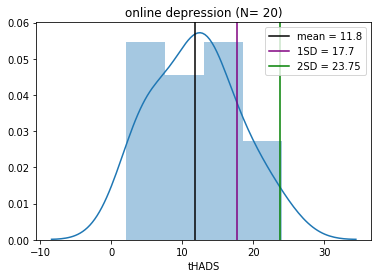

In [85]:
sns.distplot(HADS_final['tHADS'])
plt.title('online depression (N= 20)')
plt.axvline(x = 11.8, color = 'black', label = 'mean = 11.8')
plt.axvline(x = 17.7, color = 'purple', label = '1SD = 17.7')
plt.axvline(x = 23.75, color = 'green', label = '2SD = 23.75')
plt.legend(loc = 1)
#plt.savefig('figure/noprescreen/online_depression_v2.png', dpi = 300)

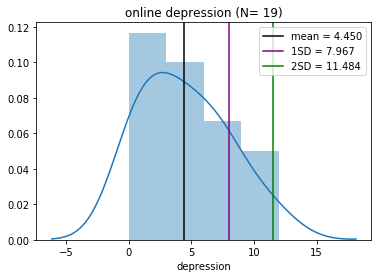

In [86]:
sns.distplot(HADS_final['depression'])
plt.title('online depression (N= 19)')
plt.axvline(x = 4.450, color = 'black', label = 'mean = 4.450')
plt.axvline(x = 7.967, color = 'purple', label = '1SD = 7.967')
plt.axvline(x = 11.484, color = 'green', label = '2SD = 11.484')
plt.legend(loc = 1)
plt.savefig('figure/noprescreen/online_depression_v2.png', dpi = 300)

# Fatigue

In [87]:
# import fatigue
fatigue = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-j95b.csv', sep = ",")
fatigue.drop(fatigue.tail(1).index,inplace=True)

In [88]:
fatigue_group = fatigue.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice_fatigue= extract_choice(fatigue_group['choice made'])
fatigue_group = fatigue_group.loc[fatigue_group.index.repeat(22)]

In [89]:
fatigue_group['choice'] = choice_fatigue
fatigue_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                  19, 20, 21,22]*20

In [90]:
# 'Never', 'Rarely', 'Sometimes', 'Often', 'Almost always'
#   0         1          2            3           4
fatigue_group.choice[fatigue_group.choice == "Never"] = 0
fatigue_group.choice[fatigue_group.choice == "Rarely"] = 1
fatigue_group.choice[fatigue_group.choice == "Sometimes"] = 2
fatigue_group.choice[fatigue_group.choice == "Often"] = 3
fatigue_group.choice[fatigue_group.choice == "Almost always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

In [91]:
fatigue_physical = fatigue_group[fatigue_group['question_number'].isin([4, 7, 8, 11, 14, 15, 18, 21, 22])]
fatigue_cognitive = fatigue_group[fatigue_group['question_number'].isin([1, 2, 3, 6, 12, 13, 16, 17, 19, 20])]
fatigue_psychological = fatigue_group[fatigue_group['question_number'].isin([9, 10])]
fatigue_trick = fatigue_group[fatigue_group['question_number'].isin([5])]

In [92]:
physical = fatigue_physical.groupby(['Participant Private ID'])['choice'].sum().reset_index()
physical.columns = ['id', 'physical']
cognitive = fatigue_cognitive.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive.columns = ['id', 'cognitive']
psychological = fatigue_psychological.groupby(['Participant Private ID'])['choice'].sum().reset_index()
psychological.columns = ['id', 'psychological']

In [93]:
fatigue_final = {'id': physical['id'], 'physical': physical['physical'], 
                'cognitive': cognitive['cognitive'],
               'psychological': psychological['psychological']}
fatigue_final = pd.DataFrame(data=fatigue_final)
fatigue_final['fatigue'] = fatigue_final['physical'] + fatigue_final['cognitive'] + fatigue_final['psychological']

# Pleasure

In [94]:
# import pleasure
pleasure = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-uvof.csv', sep = ",")
pleasure.drop(pleasure.tail(1).index,inplace=True)

In [95]:
pleasure_group = pleasure.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(pleasure_group['choice made'])
pleasure_group = pleasure_group.loc[pleasure_group.index.repeat(15)]

In [96]:
pleasure_group['choice'] = choice
pleasure_group['question_number'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]*20

In [97]:
pleasure_group.choice[pleasure_group.choice == "Strongly agree"] = 1
pleasure_group.choice[pleasure_group.choice == "Agree"] = 2
pleasure_group.choice[pleasure_group.choice == "Disagree"] = 3
pleasure_group.choice[pleasure_group.choice == "Strongly disagree"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [98]:
pleasure_final = {'id': pleasure_group['Participant Private ID']}
pleasure_final = pd.DataFrame(data=pleasure_final)
p = pleasure_group.groupby('Participant Private ID')['choice'].sum().reset_index(name = 'total')
pleasure_final['pleasure'] = p['total']
pleasure_final=pleasure_final.drop_duplicates()
len(pleasure_final)

20

In [99]:
pleasure_final.head(2)

id  pleasure
0 765957.000        20
1 765963.000        45

# Barratt

In [100]:
# import Baratt
barrat = pd.read_csv('no_prescreening_raw/data_exp_8449-v8_task-df75.csv', sep = ",")
barrat.drop(barrat.tail(1).index,inplace=True)

In [101]:
barrat_group = barrat.groupby(["Participant Private ID"])['choice made'].apply(list).reset_index()
choice = extract_choice(barrat_group['choice made'])
barrat_group = barrat_group.loc[barrat_group.index.repeat(31)]

In [102]:
barrat_group['choice'] = choice
barrat_group['question_number'] = ["att1", "mo2", "mo3", "mo4", "att5", "cogin6", 
                                   "con7", "con8", "att9", "cogcom10", "att11", "t12",
                                   "con13", "con14", "con15", "cogcom16", "per17", 
                                   "mo18","cogcom19", "mo20", "att21","per22",
                                   "mo23", "per24", "cogin25", "mo26", "cogin27", 
                                   "cogcom28", "att29", "cogcom30", "per31"]*20

In [103]:
barrat_group = barrat_group[barrat_group['question_number'].isin(["att5","att11","att29", 
                                                                  "cogin6", "cogin25", "cogin27", 
                                                                  "mo2", "mo3", "mo4", "mo18",
                                                                  "mo20", "mo23", "mo26", 
                                                                  "per17","per22","per24",
                                                                  "con15", "cogcom19", "att29"])]
barrat_group.choice[barrat_group.choice == "Rarely/Never"] = 1
barrat_group.choice[barrat_group.choice == "Occasionally"] = 2
barrat_group.choice[barrat_group.choice == "Often"] = 3
barrat_group.choice[barrat_group.choice == "Almost always/Always"] = 4

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the C

In [104]:
reverse_barrat = barrat_group[barrat_group['question_number'].isin(["att9", "att21","per31", 
                                                                    "att1", "con7", "con8", 
                                                                    "con13", "con14", "cogcom10", 
                                                                    "cogcom16","cogcom30"])]
reverse_barrat.choice[reverse_barrat.choice == "Rarely/Never"] = 4
reverse_barrat.choice[reverse_barrat.choice == "Occasionally"] = 3
reverse_barrat.choice[reverse_barrat.choice == "Often"] = 2
reverse_barrat.choice[reverse_barrat.choice == "Almost always/Always"] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3291: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [105]:
attention = barrat_group[(barrat_group.question_number == "att5")|(barrat_group.question_number == "att9")|
                         (barrat_group.question_number == "att11")|(barrat_group.question_number == "att21")|
                         (barrat_group.question_number == "att29")]
cognitive_instable = barrat_group[(barrat_group.question_number == "cogin6")|(barrat_group.question_number == "cogin25")|
                                  (barrat_group.question_number == "cogin27")]
motor = barrat_group[(barrat_group.question_number == "mo2")|(barrat_group.question_number == "mo3")|
                     (barrat_group.question_number == "mo4")|(barrat_group.question_number == "mo18")|
                     (barrat_group.question_number == "mo20")|(barrat_group.question_number == "mo23")|
                     (barrat_group.question_number == "mo26")]
perseverance = barrat_group[(barrat_group.question_number == "per17")|(barrat_group .question_number == "per22")|
                            (barrat_group.question_number == "per24")|(barrat_group.question_number == "per31")]
self_control = barrat_group[(barrat_group.question_number == "con1")|(barrat_group.question_number == "con7")|
                            (barrat_group.question_number == "con8")|(barrat_group.question_number == "con13")|
                            (barrat_group.question_number == "con14")|(barrat_group.question_number == "con15")]
cognitive_complexity = barrat_group[(barrat_group.question_number == "cogcom10")|(barrat_group.question_number == "cogcom16")|
                                    (barrat_group.question_number == "cogcom19")|(barrat_group.question_number == "cogcom28")|
                                    (barrat_group.question_number == "cogcom30")]
trick = barrat_group[barrat_group.question_number == "t12"]

In [106]:
temp = pd.concat([attention, cognitive_instable, motor, perseverance,self_control,cognitive_complexity])
temp.columns = ["id", 'choice_made', 'choice', 'question_number']
temp = temp[['id', 'choice', 'question_number']]
temp.head(2)

id choice question_number
0 765957.000      3            att5
0 765957.000      3           att11

In [107]:
pca_table = pd.concat([pca_table, temp])

In [108]:
attention = attention.groupby(['Participant Private ID'])['choice'].sum().reset_index()
attention.columns = ['id', 'attention']
cognitive_instable = cognitive_instable.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_instable.columns = ['id', 'cognitive_instable']
motor = motor.groupby(['Participant Private ID'])['choice'].sum().reset_index()
motor.columns = ['id', 'motor']
perseverance = perseverance.groupby(['Participant Private ID'])['choice'].sum().reset_index()
perseverance.columns = ['id', 'perseverance']
self_control = self_control.groupby(['Participant Private ID'])['choice'].sum().reset_index()
self_control.columns = ['id', 'self_control']
cognitive_complexity = cognitive_complexity.groupby(['Participant Private ID'])['choice'].sum().reset_index()
cognitive_complexity.columns = ['id', 'cognitive_complexity']

In [109]:
barrat_final = {'id': attention['id'], 'attention': attention['attention'], 
                'cognitive_instable': cognitive_instable['cognitive_instable'],
               'motor': motor['motor'],
               'perseverance': perseverance['perseverance'],
               'self_control': self_control['self_control'],
               'cognitive_complexity': cognitive_complexity['cognitive_complexity']}
barrat_final = pd.DataFrame(data=barrat_final)
barrat_final['attentional'] = attention['attention'] + cognitive_instable['cognitive_instable']
barrat_final['motor_0'] = motor['motor'] + perseverance['perseverance']
barrat_final['nonplanning'] = self_control['self_control'] + cognitive_complexity['cognitive_complexity']
barrat_final['impulsivity'] = barrat_final['attentional'] + barrat_final['motor_0'] + barrat_final['nonplanning']

# one large table for all the scales

In [110]:
data_frames = [AMI_final, HADS_final, fatigue_final, pleasure_final, barrat_final]

In [111]:
scale = pd.merge(AMI_final, HADS_final, on = ['id'], how = 'inner')

In [112]:
scale = pd.merge(scale, fatigue_final, on = ['id'], how = 'inner')

In [113]:
scale = pd.merge(scale, pleasure_final, on = ['id'], how = 'inner')

In [114]:
scale = pd.merge(scale, barrat_final, on = ['id'], how = 'inner')

In [116]:
scale.to_csv('noprescreen_dataset/scale_fisherman2_noprescreening.csv', sep = ',', encoding='utf-8')

# Correlation table for scales and betas

In [136]:
AMI_final['id']=AMI_final['id'].astype('str')
HADS_final['id']=HADS_final['id'].astype('str')

In [137]:
AMI_final = AMI_final.reset_index().set_index('id')
HADS_final = HADS_final.reset_index().set_index('id')

In [138]:
HADS_final = HADS_final[['anxiety', 'depression', 'tHADS']]

In [139]:
AMI_final= AMI_final[['bAMI', 'sAMI', 'eAMI', 'tAMI']]

In [140]:
pleasure_final['id']=pleasure_final['id'].astype('str')
fatigue_final['id']=fatigue_final['id'].astype('str')
barrat_final['id']=barrat_final['id'].astype('str')

In [141]:
pleasure_final = pleasure_final.reset_index().set_index('id')
fatigue_final = fatigue_final.reset_index().set_index('id')
barrat_final = barrat_final.reset_index().set_index('id')

In [142]:
correlation_table = AMI_final.merge(random_effects, left_index=True, right_index=True, how = 'inner')
#correlation_table = AMI_prunned.join(random_effects, how='inner')

In [143]:
correlation_table = correlation_table.merge(HADS_final, left_index=True, right_index=True, how='inner')

In [144]:
correlation_table = correlation_table.merge(barrat_final, left_index=True, right_index=True, how='inner')

In [161]:
correlation_table.head(100)

bAMI  sAMI  eAMI  tAMI  Group  environment_binary[T.1]  \
id                                                                 
765957.0 1.000 1.667 1.167 1.278  0.045                    0.010   
765963.0 2.000 1.500 1.833 1.778  0.196                   -0.250   
765965.0 2.000 1.667 1.500 1.722  0.037                   -0.010   
765970.0 1.667 1.667 0.833 1.389  0.035                    0.028   
765973.0 1.833 2.000 0.667 1.500 -0.059                    0.079   
765978.0 0.500 0.833 1.000 0.778  0.089                   -0.110   
765982.0 0.833 1.333 1.000 1.056 -0.062                    0.086   
765983.0 0.500 0.167 0.167 0.278 -0.121                    0.056   
765985.0 1.833 2.667 1.333 1.944  0.041                   -0.024   
765987.0 1.000 0.500 1.833 1.111 -0.177                    0.071   
765991.0 1.500 2.667 2.167 2.111 -0.025                   -0.028   
765992.0 2.500 1.833 0.833 1.722 -0.121                    0.164   
765993.0 1.500 1.833 1.333 1.556 -0.056                    0.103   
765995.0 1.000 1.667 1.333 1.333 -0.133                   -0.012   
766000.0 1.833 2.000 0.667 1.500  0.130                   -0.065   
766002.0 1.000 2.167 1.333 1.500  0.176                   -0.008   
766004.0 1.167 3.000 1.167 1.778  0.089                    0.041   
766005.0 1.167 1.667 2.167 1.667 -0.198                    0.014   
766092.0 1.333 1.500 1.000 1.278  0.017                   -0.039   
766229.0 1.500 2.167 0.667 1.444  0.096                   -0.107   

          price_displayed  fatigue  anxiety  depression  ...  attention  \
id                                                       ...              
765957.0           -0.004   -0.000       11           7  ...          9   
765963.0           -0.003    0.000        9          10  ...          6   
765965.0           -0.013    0.000       12           9  ...          6   
765970.0            0.003    0.000        6           5  ...          4   
765973.0            0.017    0.000        7           5  ...          5   
765978.0            0.019   -0.000        6           0  ...          3   
765982.0            0.017   -0.000        9           3  ...          5   
765983.0           -0.003    0.000        9           3  ...          4   
765985.0            0.009   -0.000       12          12  ...          5   
765987.0           -0.001   -0.000        3           1  ...          3   
765991.0            0.014    0.000        9           7  ...          4   
765992.0            0.015    0.000       10           4  ...          7   
765993.0           -0.002   -0.000        5           0  ...          7   
765995.0            0.020    0.000        4           2  ...          3   
766000.0           -0.018   -0.000        5           4  ...          6   
766002.0            0.003    0.000        6           7  ...          5   
766004.0           -0.007   -0.000        7           7  ...          3   
766005.0           -0.012   -0.000        1           1  ...          7   
766092.0            0.011    0.000       11           2  ...          5   
766229.0           -0.065    0.000        5           0  ...          5   

          cognitive_instable  motor  perseverance  self_control  \
id                                                                
765957.0                   7     18             6             2   
765963.0                   6     14             6             2   
765965.0                   7     17             6             2   
765970.0                   5     17             4             2   
765973.0                   5     12             4             2   
765978.0                   5     15             3             2   
765982.0                   6     12             6             1   
765983.0                   8     18             5             2   
765985.0                   4     13             4             3   
765987.0                   4     18             5             2   
765991.0                   5     12             3         

In [505]:
a = correlation_table['bAMI']
b = correlation_table['total']
ss.spearmanr(a,b)

SpearmanrResult(correlation=0.30274321751224037, pvalue=0.1944821947534181)

In [508]:
a = correlation_table['bAMI']
b = correlation_table['nonplanning']
ss.spearmanr(a,b)

SpearmanrResult(correlation=0.6650031524305843, pvalue=0.0013780796645605112)

In [510]:
a = correlation_table['sAMI']
b = correlation_table['motor_0']
ss.spearmanr(a,b)

SpearmanrResult(correlation=-0.4847234243020185, pvalue=0.030307030636749558)

In [515]:
a = correlation_table['tAMI']
b = correlation_table['attentional']
ss.spearmanr(a,b)

SpearmanrResult(correlation=0.1312567965482601, pvalue=0.5812240907525017)

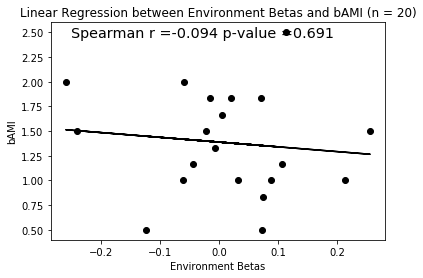

In [609]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['bAMI']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Environment Betas")
plt.ylabel("bAMI")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Environment Betas and bAMI (n = 20)')
plt.annotate('Spearman r =-0.094 p-value =0.691', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/noprescreen/env_bAMI_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [610]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.147787930475141, pvalue=0.5340730326802884)

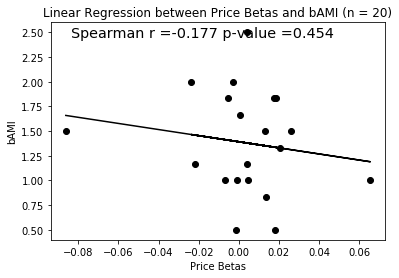

In [611]:
x = correlation_table['price_displayed']
y = correlation_table['bAMI']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Price Betas")
plt.ylabel("bAMI")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Price Betas and bAMI (n = 20)')
plt.annotate('Spearman r =-0.177 p-value =0.454', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/noprescreen/price_bAMI_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [612]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.19022959256030966, pvalue=0.42178388007029555)

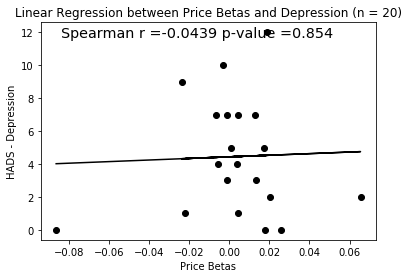

In [616]:
x = correlation_table['price_displayed']
y = correlation_table['depression']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Price Betas")
plt.ylabel("HADS - Depression")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Price Betas and Depression (n = 20)')
plt.annotate('Spearman r =-0.0439 p-value =0.854', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/noprescreen/price_depression_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [617]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.20371598758624823, pvalue=0.3889791928350649)

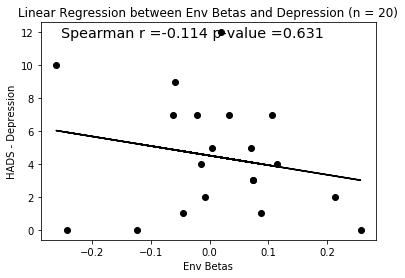

In [618]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['depression']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Env Betas")
plt.ylabel("HADS - Depression")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Env Betas and Depression (n = 20)')
plt.annotate('Spearman r =-0.114 p-value =0.631', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/noprescreen/env_depression_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [619]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.178724806952991, pvalue=0.45089832169800337)

In [620]:
ss.pearsonr(x,y)

(-0.21183773393667452, 0.3699305766208849)

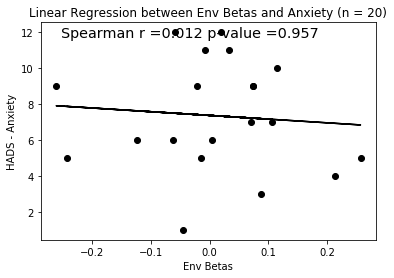

In [621]:
x = correlation_table['environment_binary[T.1]']
y = correlation_table['anxiety']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Env Betas")
plt.ylabel("HADS - Anxiety")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Env Betas and Anxiety (n = 20)')
plt.annotate('Spearman r =0.012 p-value =0.957', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/noprescreen/env_anxiety_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [622]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.06366249312775304, pvalue=0.7897422425819685)

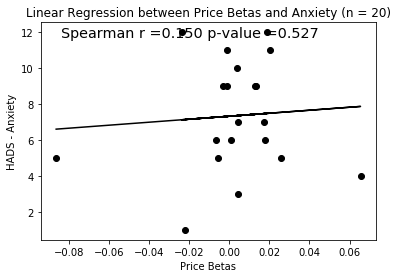

In [623]:
x = correlation_table['price_displayed']
y = correlation_table['anxiety']

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Price Betas")
plt.ylabel("HADS - Anxiety")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Price Betas and Anxiety (n = 20)')
plt.annotate('Spearman r =0.150 p-value =0.527', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/noprescreen/env_anxiety_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [624]:
ss.spearmanr(x,y)

SpearmanrResult(correlation=0.05684151172120808, pvalue=0.8118602325195134)